# Compare clustering methods

Here, we test the robustness of the method and clusters obtained by comparing several clustering methods. 

In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import seaborn as sb

# from sklearn.metrics import adjusted_rand_score # function used to compute similarity between sets of clusters

import phasik as pk

sb.set_context("paper")

### 1. Build temporal network of PPI

In [2]:
# load static PPI network
static_net_filepath = "../data/kegg/static_PPI_network_KEGG.adjlist"
static_network = nx.read_adjlist(static_net_filepath)  # networkx Graph object

pk.graph_size_info(static_network)

# load edge time series
edge_activity_filepath = "../data/chen/edge_time_series_normed.csv"
norm = True

# use this for non-normalised time series
# edge_activity_filepath = "data/chen/edge_time_series.csv"
# norm = False

edge_series = pd.read_csv(edge_activity_filepath).transpose()
times = list(edge_series.columns)

# build temporal network

# this function buils a TemporalNetwork, by integrating the edge time series to the static network,
# and setting a constant default weight value for edges for which we have no temporal information
temporal_network = pk.TemporalNetwork.from_static_network_and_edge_timeseries(
    static_network,
    edge_series,
    static_edge_default_weight=1,
    quiet=True,  # if True, prints less information
)

temporal_network_name = f"kegg_chen_normed_{norm}"

A PartiallyTemporalNetwork is created instead.


## 2. Compare clusters for each method

In [3]:
# clustering parameters
distance_metric = "euclidean"  # used to compute distance between snapshots
# list of methods to compare
clustering_methods = [
    "k_means",
    "centroid",
    "average",
    "complete",
    "weighted",
    "median",
    "single",
    "ward",
]
n_max_type = "maxclust"  # set number of clusters by maximum number of clusters wanted

n_max = 5  # max number of clusters
n_max_range = range(2, 12)  # range of numbers of clusters to compute

# plotting parameters
if norm:
    output_directory = "images/chen/normalised/"
else:
    output_directory = "images/chen/"

events_times = [5, 33, 36, 70, 84, 100]
events_labels = ["START", "bud", "ori", "E3", "spn", "mass"]
events = [(time, name, "dashed") for time, name in zip(events_times, events_labels)]

phases = [(0, 35, "G1"), (35, 70, "S"), (70, 78, "G2"), (78, 100, "M")]

time_ticks = range(101, 10)

### 2.1 Compute cluster sets for each method

In [4]:
valid_cluster_sets = []
for clustering_method in clustering_methods:
    try:
        distance_matrix = pk.DistanceMatrix.from_temporal_network(
            temporal_network, distance_metric
        )

        cluster_sets = pk.ClusterSets.from_distance_matrix(
            distance_matrix, n_max_type, n_max_range, clustering_method
        )
        valid_cluster_sets.append((cluster_sets, clustering_method))
    except Exception as e:
        print(f"Error when cluster_method = {clustering_method}: {e}")

valid_methods = [sets[1] for sets in valid_cluster_sets]

### 2.2 Plot clusters and silhouettes for each method

0 k_means
1 centroid
2 average
3 complete
4 weighted
5 median
6 single


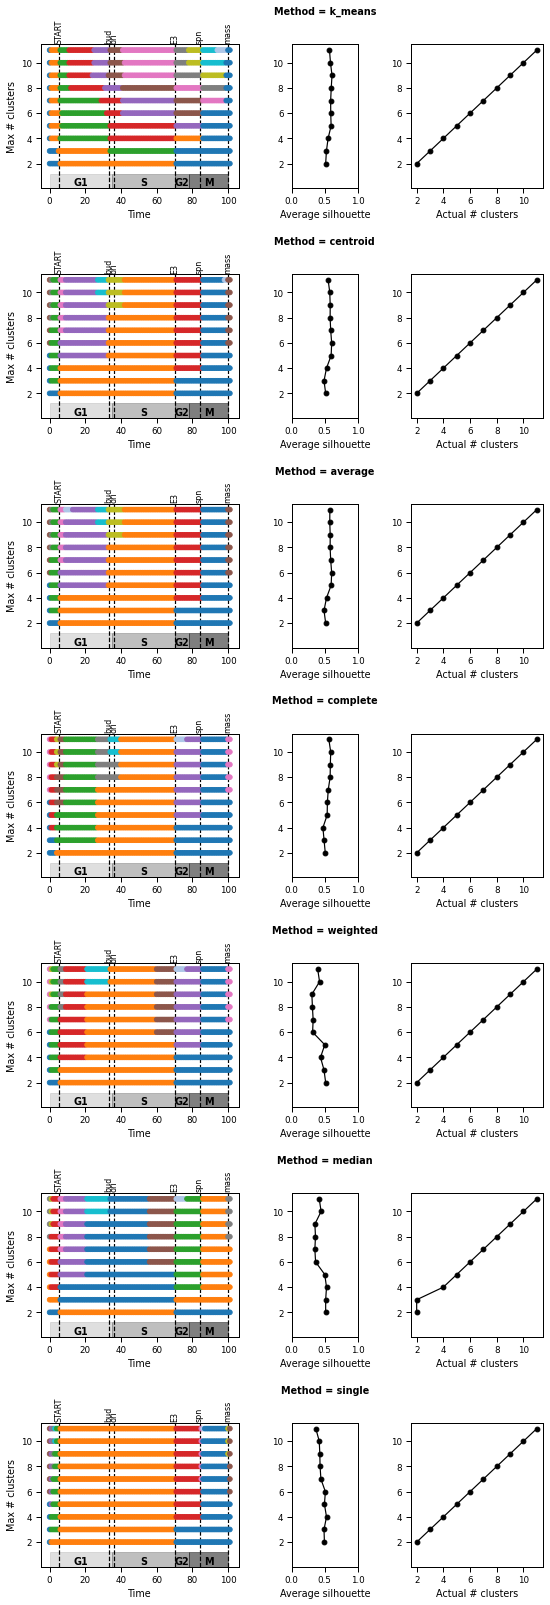

In [5]:
gridspec_kw = {"width_ratios": [3, 1, 2]}

n_set_plot = len(valid_cluster_sets[:-1])
figsize = (9, 4 * n_set_plot)
fig, axs = plt.subplots(
    n_set_plot,
    3,
    figsize=figsize,
    gridspec_kw=gridspec_kw,
    sharey="row",
    sharex="col",
)

for i, (cluster_sets, clustering_method) in enumerate(
    valid_cluster_sets[:-1]
):  # don't plot ward
    print(i, clustering_method)
    row = (axs[i, 0], axs[i, 1], axs[i, 2])
    if clustering_method == "k_means":
        coloring = "ascending"  # None
    else:
        coloring = "consistent"

    #     cluster_sets.plot(axs=row, with_silhouettes=True)
    cluster_sets.plot_and_format_with_average_silhouettes(
        row, events, phases, time_ticks, coloring=coloring
    )

    plt.subplots_adjust(wspace=0.4, hspace=0.6)
    fontdict = {"horizontalalignment": "center"}
    axs[i, 1].set_title(
        f"Method = {clustering_method}",
        fontdict=fontdict,
        fontweight="bold",
        pad=30,
    )

title = (
    temporal_network_name
    + f"\ndistance_metric={distance_metric}, cluster_limit_type={n_max_type}"
)
# fig.suptitle(title, y=0.92, weight='bold')

# Save
if output_directory is not None:
    filename = f"{output_directory}/silhouette_scores_over_cluster_methods_{pk.slugify(temporal_network_name)}"
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

### 2.4 Compute similarity of clusterings to reference method "Ward"

In [6]:
rand_index = pk.rand_index_over_methods_and_sizes(
    valid_cluster_sets, reference_method="ward"
)

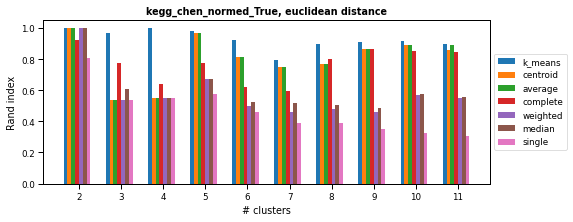

In [7]:
sb.set_palette("tab10")
fig, ax = plt.subplots(1, 1, figsize=(8, 3))

pk.plot_randindex_bars_over_methods_and_sizes(
    valid_cluster_sets, reference_method="ward", ax=ax, plot_ref=False
)

ax.set_ylabel("Rand index")
ax.set_xlabel("# clusters")

ax.legend(loc="center left", bbox_to_anchor=(1, 0.5))

ax.set_title(f"{temporal_network_name}, {distance_metric} distance", weight="bold")

# Save
if output_directory is not None:
    filename = (
        f"{output_directory}/randindex_over_methods_{pk.slugify(temporal_network_name)}"
    )
#     plt.savefig(f"{filename}.png", dpi=250, bbox_inches="tight")
#     plt.savefig(f"{filename}.svg", dpi=250, bbox_inches="tight")

plt.show()